In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook, trange
from numba import jit
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.cluster import SpectralClustering

In [2]:
os.chdir(r"/raid6/roozbeh/trip_similarity/")

In [3]:
with pd.HDFStore("koln_by_hour_OD_and_scaled.h5") as store:
    OD8df = store["OD8df"]
    OD8df_scaled = store["OD8df_scaled"]
    OD12df = store["OD12df"]
    OD12df_scaled = store["OD12df_scaled"]
    OD16df = store["OD16df"]
    OD16df_scaled = store["OD16df_scaled"]
    OD20df = store["OD20df"]
    OD20df_scaled = store["OD20df_scaled"]

#### Parameters

In [4]:
spatial_step = 50

time_threshold = 600 #seconds since data is per second

distance_sim_coef = 0.0001
time_sim_coef = 0.00015

In [9]:
x_diff = max(OD8df.x_begin.max(),OD8df.x_end.max()) - min(OD8df.x_begin.min(), OD8df.x_end.min())
y_diff = max(OD8df.y_begin.max(),OD8df.y_end.max()) - min(OD8df.y_begin.min(), OD8df.y_end.min())
min_diff = min(x_diff,y_diff)
min_step = min_diff / spatial_step 
distance_threshold = min_step * np.sqrt(2)
distance_threshold

622.9631611561606

##### We get a sample of 10000 for ongoing rides + 2000 for the requests

In [10]:
ongoingDF = OD8df.sample(n=10000,random_state=1234)

otherDF = OD8df[~ OD8df.index.isin(ongoingDF.index)]

reqDF = otherDF.sample(n=2000,random_state=1234)
reqDF.sort_values("time_begin",inplace=True)

In [9]:
def get_trip_carshare_similarity_from_tuple_scaled(t1,t2,d_th,t_th):
    sim = ( 1 - np.sqrt( (t1.x_end - t2[2]) ** 2 + (t1.y_end - t2[3])**2 )/d_th ) * ( 1 - np.absolute(t1.time_end-t2[1])/t_th ) 
    return(sim)

In [10]:
def get_trip_scaled_sim_func(req,d_th,t_th):
    return lambda t: get_trip_carshare_similarity_from_tuple_scaled(t,req,d_th,t_th)

### Car Share scenario
#### NO DYNAMIC UPDATE OF ONGOING
The ride finishes before picking another one up!

In [11]:
match_counts_per_threshold_pool = []
for i in tqdm_notebook(range(1,40)):
    thresh = i/10 * distance_threshold
    match_counts = []
    for req in reqDF.itertuples(name=None):
        DO_distance = np.sqrt( (ongoingDF.x_end - req[2])**2 + (ongoingDF.y_end - req[3])**2 )

        potential_matches = ongoingDF[(DO_distance <= thresh) & 
                                      ((req[1] >= ongoingDF.time_end) & ((req[1]-ongoingDF.time_end )<=time_threshold) )
                                     ]
        
        match_counts.append(len(potential_matches))
    
    match_counts_per_threshold_pool.append((i,thresh,match_counts))

A Jupyter Widget

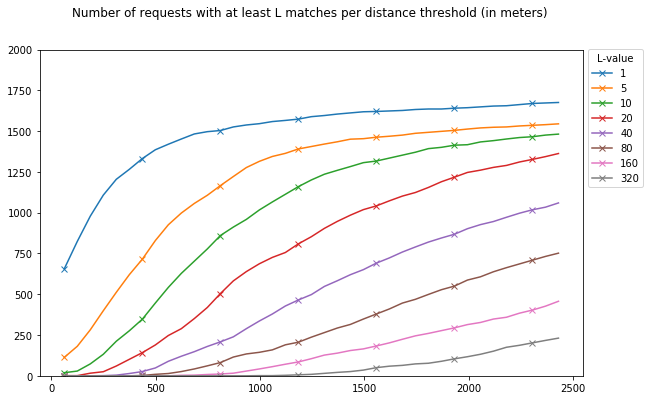

In [31]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca()
ax.set_ylim((0,2000))
fig.set_size_inches((10,6))
fig.suptitle("Number of requests with at least L matches per distance threshold (in meters)" )
for l in [1,5,10,20,40,80,160,320]:
    at_least_l_matches = [(j,len([t for t in k if t>=l])) for (i,j,k) in match_counts_per_threshold_pool]
    thresh,ncount = zip(*at_least_l_matches)
    ax.plot(thresh,ncount,label=l,marker="x",markevery=6)
plt.legend(loc=0,bbox_to_anchor=(1, 1.017),title="L-value")
plt.subplots_adjust(right=0.88)

#### WITH DYNAMIC UPDATE OF RIDES TO THE MATCHED ONES!

In [11]:
match_counts_per_threshold_pool_dyn = []
matched_to_counts_per_threshold = [] # to count how long of a chain we can make with this!

Let's make copies for ongoing multiple times!

In [12]:
ongoings = [ongoingDF.copy() for i in range(1,40)]

In [13]:
for i in tqdm_notebook(range(1,40)):
    ongoingcp = ongoings[i-1]
    thresh = i/10 * distance_threshold
    match_counts = []
    matched_to_counts = {}
    for req in reqDF.itertuples(name=None):
        DO_distance = np.sqrt( (ongoingcp.x_end - req[2])**2 + (ongoingcp.y_end - req[3])**2 )
        
        potential_matches = ongoingcp[(DO_distance <= thresh) & 
                                      ((req[1] >= ongoingcp.time_end) & ((req[1]-ongoingcp.time_end )<=time_threshold) )
                                     ]

        match_counts.append(len(potential_matches))
        
        if not potential_matches.empty:
            trip_sim_func = get_trip_scaled_sim_func(req,thresh,time_threshold)
            
            potential_matches["similarity"] = potential_matches.apply(trip_sim_func,axis=1)
        
            top_match = potential_matches.loc[potential_matches["similarity"].idxmax(),:]
            ongoingcp.loc[top_match.name,:] = req[1:] #update 

            if top_match.name in matched_to_counts:
                matched_to_counts[top_match.name]+=1
            else:
                matched_to_counts[top_match.name]=1

    matched_to_counts_per_threshold.append((thresh,matched_to_counts))
    match_counts_per_threshold_pool_dyn.append((i,thresh,match_counts))

HBox(children=(IntProgress(value=0, max=39), HTML(value='')))

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
[sorted(list(Counter(cperth.values()).items())) for (th,cperth) in  matched_to_counts_per_threshold][:10]

[[(1, 543), (2, 34), (3, 5)],
 [(1, 659), (2, 57), (3, 8)],
 [(1, 759), (2, 80), (3, 9), (4, 1)],
 [(1, 847), (2, 91), (3, 11), (4, 1)],
 [(1, 906), (2, 107), (3, 11), (4, 2)],
 [(1, 953), (2, 113), (3, 12), (4, 1)],
 [(1, 989), (2, 119), (3, 14), (4, 2)],
 [(1, 1029), (2, 126), (3, 15), (4, 2)],
 [(1, 1047), (2, 133), (3, 17), (4, 2), (5, 1)],
 [(1, 1066), (2, 141), (3, 18), (4, 2), (5, 1)]]

In [15]:
c = [1,2,3,4,5,6]
sum_freq = [0,0,0,0,0,0]
count_freq = [0,0,0,0,0,0]
for th,cperth in matched_to_counts_per_threshold:
    for c1,v1 in (Counter(cperth.values()).items()):
        sum_freq[c1-1] += v1
        count_freq[c1-1] += 1

In [16]:
avg_freq = np.array(sum_freq)/np.array(count_freq)

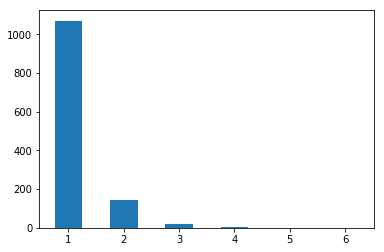

In [19]:
%matplotlib inline

plt.bar(c,avg_freq,width=0.5)
plt.show()

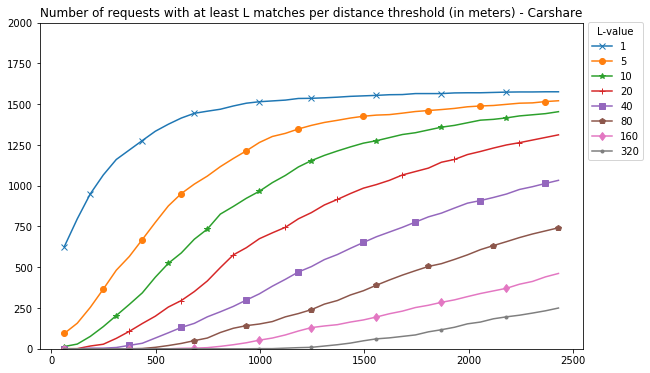

In [30]:
%matplotlib inline
markers = itertools.cycle(('x', 'o', '*', '+','s','p','d', '.')) 

fig = plt.figure(figsize=(10,6))
ax = fig.gca()
ax.set_ylim((0,2000))

ax.set_title("Number of requests with at least L matches per distance threshold (in meters) - Carshare" )
for l in [1,5,10,20,40,80,160,320]:
    at_least_l_matches = [(j,len([t for t in k if t>=l])) for (i,j,k) in match_counts_per_threshold_pool_dyn]
    thresh,ncount = zip(*at_least_l_matches)
    ax.plot(thresh,ncount,label=l,marker=next(markers),markevery=0.1)
plt.legend(loc=0,bbox_to_anchor=(1, 1.017),title="L-value")
plt.subplots_adjust(right=0.88)

TOOD: CHECK IF WE CAN FIND A RIDE BACK OR IT IS NOT A MATCH!!

##### Building the whole time - space grid!

In [16]:
match_counts_per_time_per_dist = []
for t_th in tqdm_notebook([60,300,600,900,1200,1500,1800]):
    for d_th in [0.2*i*distance_threshold for i in range(16)]:
        for req in reqDF.itertuples(name=None):
            OO_distance = np.sqrt( (ongoingDF.x_begin - req[2]) ** 2 + (ongoingDF.y_begin - req[3])**2 )
            DD_distance = np.sqrt( (ongoingDF.x_end - req[6]) ** 2 + (ongoingDF.y_end - req[7])**2 )

            potential_matches = ongoingDF[(OO_distance <= d_th) & 
                                          (DD_distance <= d_th) &
                                          ((req[1] >= ongoingDF.time_begin) & ((req[1]-ongoingDF.time_begin )<=t_th) ) &
                                          ((req[5] <= ongoingDF.time_end) & (( ongoingDF.time_end-req[5])<=t_th))
                                         ]

            match_counts_per_time_per_dist.append((t_th,d_th,len(potential_matches)))    

A Jupyter Widget

In [19]:
match_counts_pool_per_time_per_dist_df = pd.DataFrame(match_counts_per_time_per_dist,columns=["time_threshold","distance_threshold","match_counts"])

In [20]:
# store.open()
# store["match_counts_carpool_per_time_and_dist_thresh_df"] = match_counts_pool_per_time_per_dist_df
# store.close()

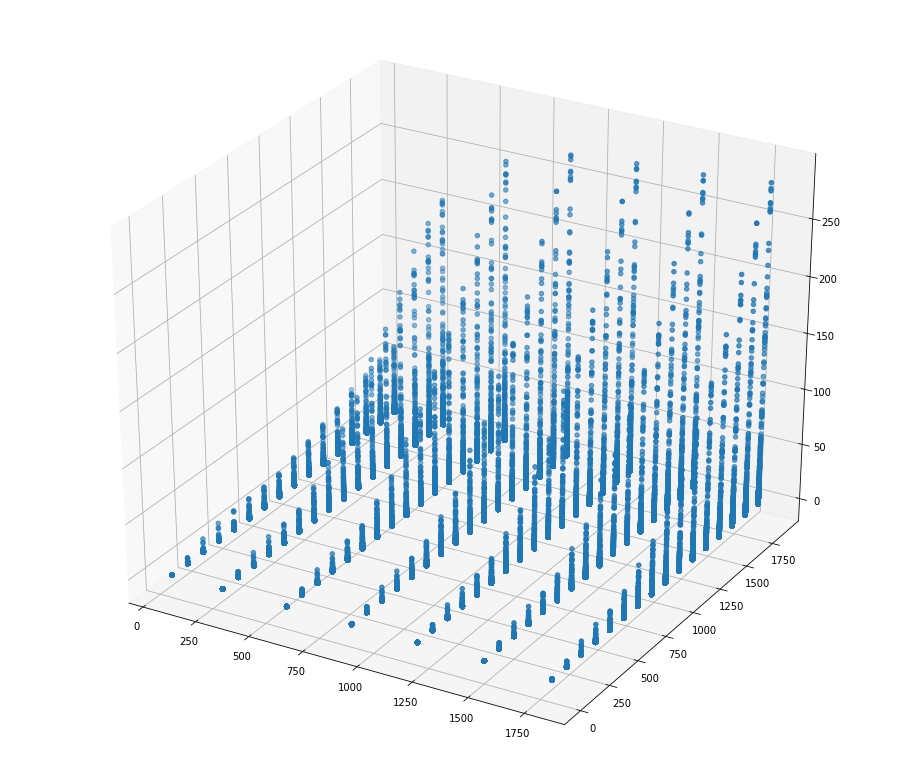

In [21]:
fig = plt.figure(figsize=(16,14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(match_counts_pool_per_time_per_dist_df["time_threshold"],
           match_counts_pool_per_time_per_dist_df["distance_threshold"],
           match_counts_pool_per_time_per_dist_df["match_counts"])
# plot_surface ??????????????????????
plt.show()

In [28]:
l_list = [1,2,5,10,20,40,80,160,320]
temp = match_counts_pool_per_time_per_dist_df.groupby(["time_threshold","distance_threshold"])\
        .apply(lambda x: [len(x[x.match_counts >= l]) for l in l_list])\
        .reset_index(name="l_counts")
l_df = pd.DataFrame( temp.l_counts.values.tolist(),columns=list(map(lambda x: "l_"+str(x),[1,2,5,10,20,40,80,160,320]))  )
l_df = pd.concat([temp.drop("l_counts",axis=1),l_df],axis=1)

In [29]:
l_df.iloc[:3]

,time_threshold,distance_threshold,l_1,l_2,l_5,l_10,l_20,l_40,l_80,l_160,l_320
0,60,0.000000,0,0,0,0,0,0,0,0,0
1,60,124.592632,27,7,3,0,0,0,0,0,0
2,60,249.185264,56,14,3,1,0,0,0,0,0


In [30]:
fig = plt.figure(figsize=(12,30))
time_groups = l_df.groupby("time_threshold")
group_len = len(time_groups)
for idx,(t_th, t_group) in enumerate(time_groups,start=1):
    ax = fig.add_subplot(group_len,1,idx)
    ax.set_ylim((0,2000))
    ax.set_ylabel("count of requests with at least L matches")
    ax.set_xlabel("distance threshold (meters)")
    for col_i,_col in enumerate(t_group.columns[2:]):
        ax.plot(t_group.distance_threshold,
                t_group[_col],
                label=l_list[col_i],marker="x")
        
    ax.set_title("time threshold="+str(t_th))
        

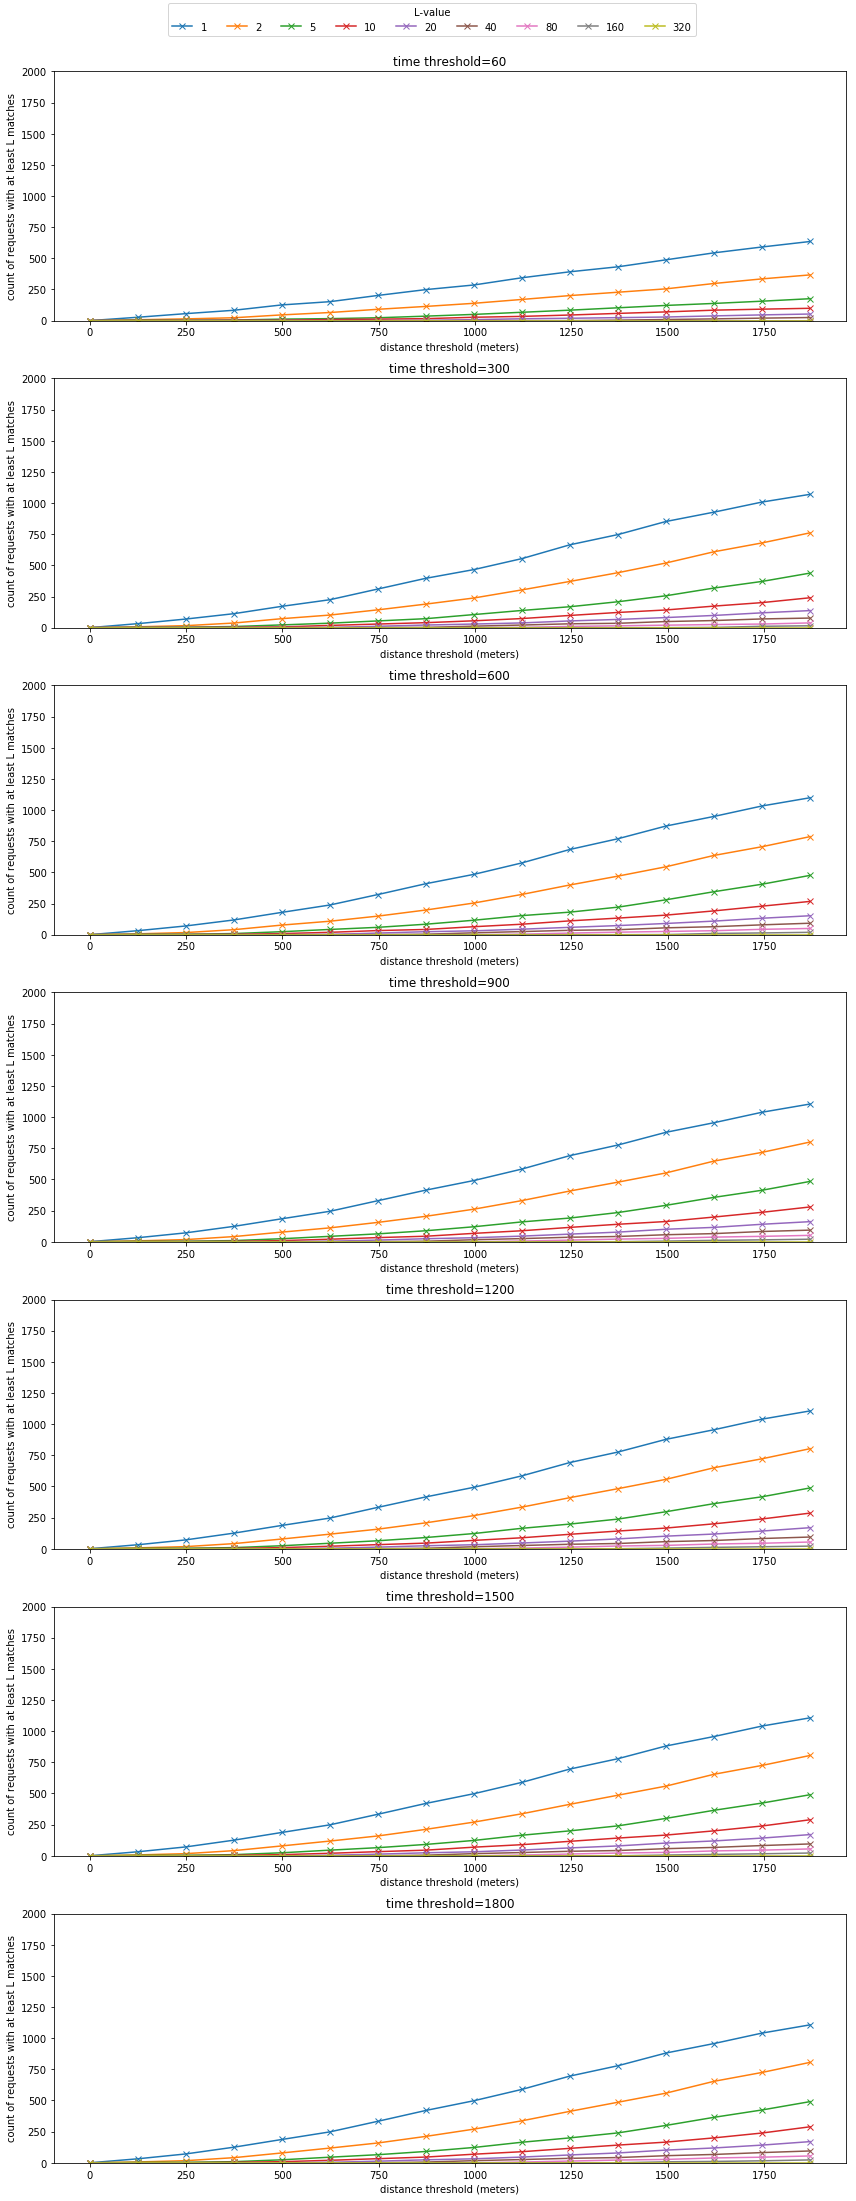

In [31]:
fig.legend(title="L-value",loc='upper center', ncol=9, bbox_to_anchor=(0.5,1.02))
plt.tight_layout()
plt.show()

In [26]:
fig = plt.figure(figsize=(12,60))
d_groups = l_df.groupby("distance_threshold")
group_len = len(d_groups)
for idx,(d_th, d_group) in enumerate(d_groups,start=1):
    ax = fig.add_subplot(group_len,1,idx)
    ax.set_ylim((0,2000))
    ax.set_ylabel("count of requests with at least L matches")
    ax.set_xlabel("time threshold (seconds)")
    for col_i,_col in enumerate(d_group.columns[2:]):
        ax.plot(d_group.time_threshold,
                d_group[_col],
                label=l_list[col_i],marker="x")
        
    ax.set_title("distance threshold="+str(d_th))

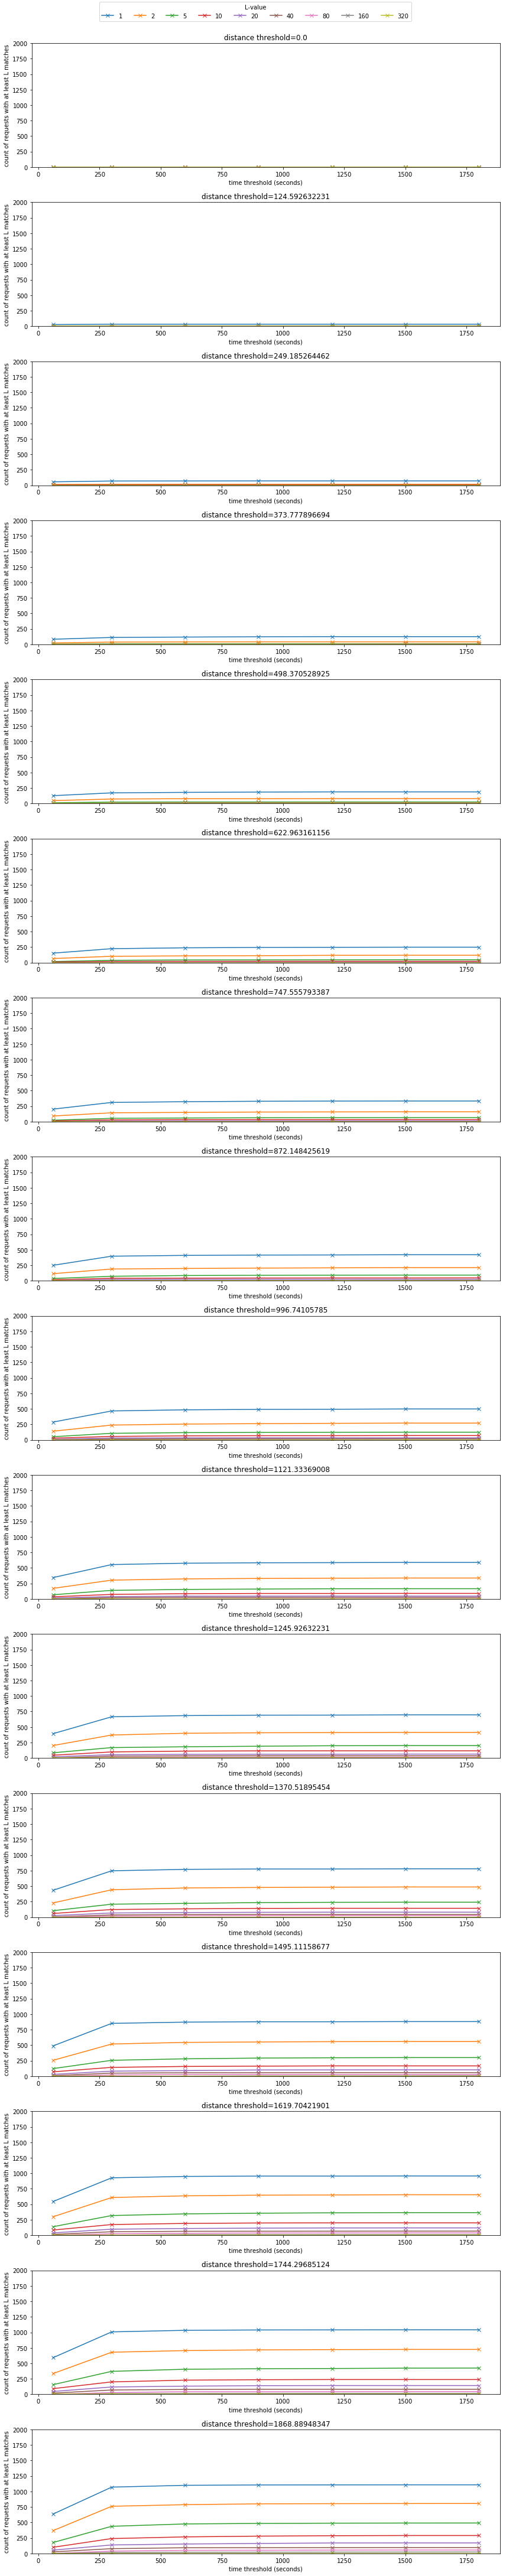

In [27]:
fig.legend(title="L-value",loc='upper center', ncol=9, bbox_to_anchor=(0.5,1.01))
plt.tight_layout()
plt.show()

In [13]:
results = []
t_th = 900 # 15 minutes
d_th = distance_threshold * 3 # almost 2km 
ongoing_counts = dict()

for req in tqdm_notebook(reqDF.itertuples(name=None),total=2000):
    OO_distance = np.sqrt( (ongoingDF.x_begin - req[2]) ** 2 + (ongoingDF.y_begin - req[3])**2 )
    DD_distance = np.sqrt( (ongoingDF.x_end - req[6]) ** 2 + (ongoingDF.y_end - req[7])**2 )

    potential_matches = ongoingDF[(OO_distance <= d_th) & 
                                  (DD_distance <= d_th) &
                                  ((req[1] >= ongoingDF.time_begin) & ((req[1]-ongoingDF.time_begin )<=t_th) ) &
                                  ((req[5] <= ongoingDF.time_end) & (( ongoingDF.time_end-req[5])<=t_th))
                                 ]

#     trip_sim_func = get_trip_sim_func(req,d_th,t_th)
    trip_sim_func = get_trip_scaled_sim_func(req,d_th,t_th)

    if potential_matches.empty:
        results.append((req,[]))
    else:
        potential_matches["similarity"] = potential_matches.apply(trip_sim_func,axis=1)

        top_matches = potential_matches.sort_values(by="similarity",ascending=False)
                
        results.append( (req, top_matches[:5]) )
        
        if top_matches.index.values[0] in ongoing_counts:
            ongoing_counts[top_matches.index.values[0]]+=1
        else:
            ongoing_counts[top_matches.index.values[0]]=1
        

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
 c,v = zip(*Counter(ongoing_counts.values()).items())

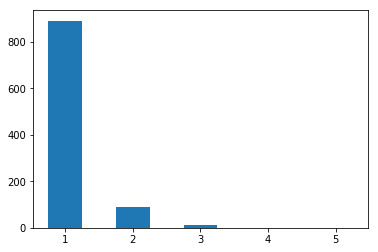

In [15]:
plt.bar(c,v,width=0.5)
plt.show()

Counting km needed 

In [50]:
km_needed = np.int64(0)
km_traveled = np.int64(0)

km_needed = np.sum(np.sqrt((ongoingDF.x_begin - ongoingDF.x_end)**2 + (ongoingDF.y_begin - ongoingDF.y_end)**2))
km_needed += np.sum(np.sqrt((reqDF.x_begin - reqDF.x_end)**2 + (reqDF.y_begin - reqDF.y_end)**2))

In [51]:
for req , matches in results:
    
    req_od = np.sqrt( (req[2] - req[6]) ** 2 + (req[3] - req[7])**2 )
    
    if(type(matches) is list): #that is if there was no match, it has to travel completely! so nothing is saved
        km_traveled += req_od
        continue
    
    m = matches[:1]

    oo = np.sqrt( (req[2] - m.x_begin)**2 + (req[3] - m.y_begin)**2 ).values[0]
    m_od = np.sqrt((m.x_begin - m.x_end)**2 + (m.y_begin - m.y_end)**2).values[0]
    dd = np.sqrt((m.x_end - req[6])**2 + (m.y_end - req[7])**2).values[0] 
    
    km_traveled += oo + dd + req_od

There are some rides that don't pick up anyone!

In [52]:
no_passenger_rides = ongoingDF[~ ongoingDF.index.isin(ongoing_counts.keys())]

In [53]:
km_traveled += np.sum(np.sqrt((no_passenger_rides.x_begin - no_passenger_rides.x_end)**2 + (no_passenger_rides.y_begin - no_passenger_rides.y_end)**2))

In [54]:
km_traveled, km_needed, km_traveled / km_needed

(50836363.678376213, 52500659.573500894, 0.96829952406988973)

#### Let's just count only those that have a match and see if they don't carpool how much is used vs if they do!

In [61]:
km_needed = np.int64(0)
km_traveled = np.int64(0)

In [62]:
for req , matches in results:
    
    if(type(matches) is list): #that is if there was no match, it has to travel completely! so nothing is saved
        continue
    
    m = matches[:1]

    req_od = np.sqrt( (req[2] - req[6]) ** 2 + (req[3] - req[7])**2 )
    oo = np.sqrt( (req[2] - m.x_begin)**2 + (req[3] - m.y_begin)**2 ).values[0]
    m_od = np.sqrt((m.x_begin - m.x_end)**2 + (m.y_begin - m.y_end)**2).values[0]
    dd = np.sqrt((m.x_end - req[6])**2 + (m.y_end - req[7])**2).values[0] 
    
    km_traveled += oo + dd + req_od
    km_needed += req_od + m_od

In [63]:
km_traveled, km_needed, km_traveled / km_needed

(5025579.090945662, 7031415.6343580466, 0.71473218940277972)

#### Let's get the distribution for trip distances and times

In [64]:
import seaborn as sns

In [65]:
ongoing_distances = np.sqrt((ongoingDF.x_begin - ongoingDF.x_end)**2 + (ongoingDF.y_begin - ongoingDF.y_end)**2)
req_distances = np.sqrt((reqDF.x_begin - reqDF.x_end)**2 + (reqDF.y_begin - reqDF.y_end)**2)
ongoing_time = ongoingDF.time_end - ongoingDF.time_begin
req_time = reqDF.time_end - reqDF.time_begin

In [93]:
cdf_args = dict(hist=False,hist_kws=dict(cumulative=True),kde_kws=dict(cumulative=True))

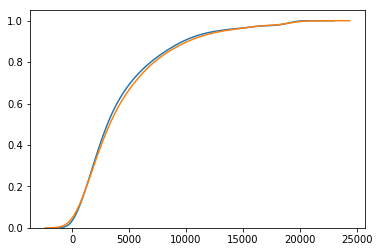

In [96]:
# plt.subplot(121)
sns.distplot(ongoing_distances,**cdf_args)
# plt.subplot(122)
sns.distplot(req_distances,**cdf_args)
plt.gcf().set_size_inches(6, 4, forward=True)


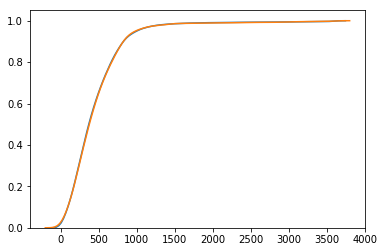

In [97]:
# plt.subplot(121)
sns.distplot(ongoing_time,**cdf_args)
# plt.subplot(122)
sns.distplot(req_time,**cdf_args)
plt.gcf().set_size_inches(6, 4, forward=True)

In [ ]:
sns.c